Para exemplificar o uso das implementações da DFT em python, será realizado um exercício de análise de sinais de áudio.

O primeiro exercício consiste em analisar o espectro de um sinal de áudio puro.

O segundo, buscando avaliar o comportamento da STFT implementada no scipy.signal. Para esse exercício será analisado o espectrograma de um sinal de audio que sofre com um ruído de decaimento exponencial.

In [435]:
import numpy as np
from scipy.fft import fft, fftshift, ifft, rfft, irfft, fftfreq
from scipy.signal import stft, istft
import matplotlib.pyplot as plt
from scipy.io import wavfile

### A DFT em Python

In [436]:
# Carrega o arquivo de áudio
sampling_rate, sinal = wavfile.read('Practice-Pad-Single-Stroke.wav')

# esse sinal de áudio tem N amostras, amostradas com frequência de sampling_rate
print(f'Número de amostras: {len(sinal)}')
print(f'Frequência de amostragem: {sampling_rate} Hz')

Número de amostras: 23994
Frequência de amostragem: 44100 Hz


/tmp/ipykernel_10470/1877645677.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, sinal = wavfile.read('Practice-Pad-Single-Stroke.wav')


#### DFT

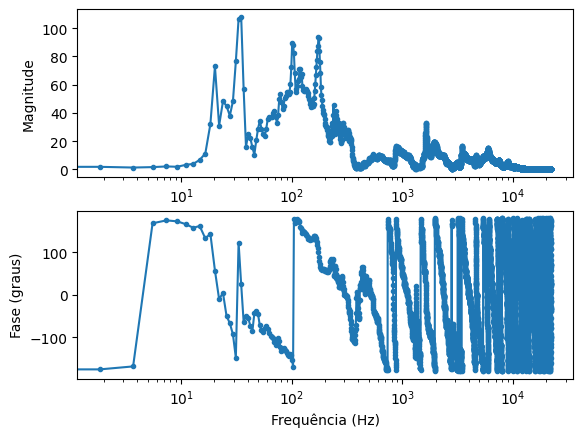

In [437]:
# plotando o espectro de frequências do sinal de áudio

# tamanho do sinal
N = len(sinal)

# Determina a FFT
fft_sinal = fftshift(fft(sinal, N)) # valores complexos das frequências
frequencias = fftshift(fftfreq(N, 1/sampling_rate)) # frequências de cada componente

# Plot das componentes de frequência
plt.figure()
plt.subplot(2,1,1)
plt.plot(frequencias, np.abs(fft_sinal)/N, '.-')
plt.ylabel('Magnitude')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(frequencias, np.degrees(np.angle(fft_sinal)), '.-')
plt.ylabel('Fase (graus)')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')
plt.show()

O gráfico acima é o espectro de frequência do sinal de áudio feito a partir da DFT do sinal. Com os valores retornados pela DFT pode-se extrair o módulo e a fase do sinal. O módulo é o que representa a magnitude do sinal, enquanto a fase representa a posição do sinal no tempo. O gráfico acima mostra que o sinal possui uma componente de frequência mais significativa em torno de 40Hz. Pode-se também observar que as demais componentes de frequência do sinal de áudio com maior magnitude estão localizadas entre 20Hz e 300Hz, com pico em 40Hz (aproximadamente), isso se dá pois o instrumento musical usado para gerar essa frequência possui um som mais grave.

Ou seja, a partir da DFT do sinal pode-se analisar quais são as componentes de frequência mais significativas do sinal e seus respectivos desvios angulares (suas características, em resumo). Isso é útil em diversas áreas da tecnologia pois podemos simplificar o sinal apenas nas componentes mais relevantes e assim, reduzir o tamanho do sinal, sem perder muita informação para a posterior reconstrução do sinal de áudio no tempo. Essa aplicação é utilizada na telecomunicação (para envio de voz), compressão de dados e em diversas outras áreas. 



Note que com quanto mais amostras realizarmos a DFT do sinal, em mais exponencias complexas o sinal poderá ser decomposto, e portanto representará com mais precisão o valor real. No exemplo a seguir o gráfico será plotado com apenas um décimo do número de amostras do sinal de áudio.

Para reduzir o número de amostras, irei remover 9 a cada 10 amostras do sinal de áudio e dividir a sample_rate por 10.

In [438]:
# criação do novo sinal a partir do sinal antigo
novo_sinal = []
count = 0
for idx, amostra in enumerate(sinal):
    if count == 9:
        novo_sinal.append(amostra)
        count = 0
        continue
    count += 1

len(sinal), len(novo_sinal)

(23994, 2399)

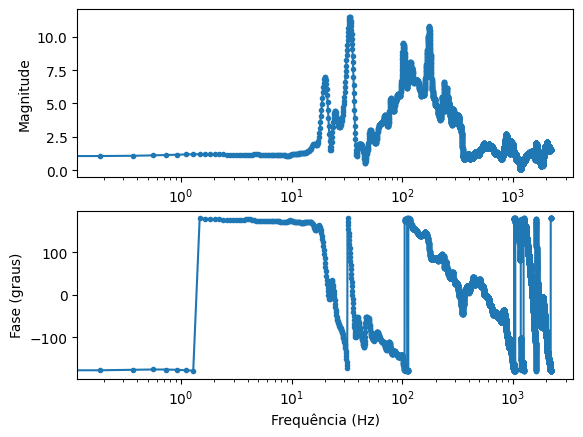

In [439]:
# plotando o espectro de frequências do novo sinal de áudio

# Determina a FFT
fft_novo_sinal = fftshift(fft(novo_sinal, N)) # valores complexos das frequências
frequencias = fftshift(fftfreq(N, 10/sampling_rate)) # frequências de cada componente

# Plot das componentes de frequência
plt.figure()
plt.subplot(2,1,1)
plt.plot(frequencias, np.abs(fft_novo_sinal)/N, '.-')
plt.ylabel('Magnitude')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')

plt.subplot(2,1,2)
plt.plot(frequencias, np.degrees(np.angle(fft_novo_sinal)), '.-')
plt.ylabel('Fase (graus)')
plt.xlabel('Frequência (Hz)')
plt.xscale('log')
plt.show()

#### STFT

Para demonstrar a STFT, vamos analisar o espectrograma de um sinal de áudio que sofre com um ruído de decaimento exponencial. O sinal de áudio é o mesmo do exercício anterior, porém com um ruído de decaimento exponencial.

[ 2.44741116e+004  6.25791276e+004  2.44657261e+004 ...  2.82699698e-205
 -2.47143185e-204 -1.43378176e-204]
[-12 -51  17 ...  -6  -3  -8]
[ 2.44621116e+04  6.25281276e+04  2.44827261e+04 ... -6.00000000e+00
 -3.00000000e+00 -8.00000000e+00]


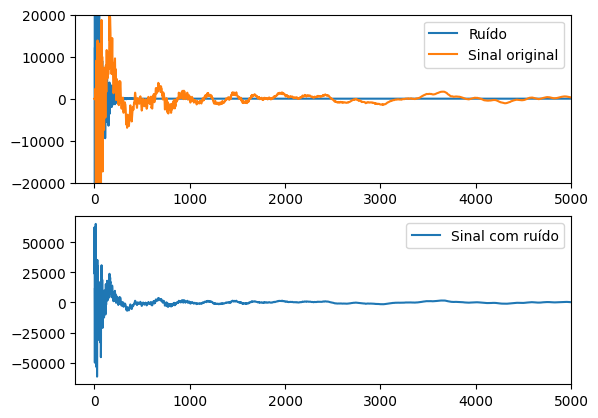

In [448]:
rng = np.random.default_rng()

duracao = np.arange(N) # duração do sinal em segundos
ruido = rng.normal(scale=sampling_rate, size=duracao.shape) # ruído branco "aleatório"
ruido *= np.exp(-duracao/50) # decaimento exponencial adicionado ao ruído

sinal_ruido = sinal + ruido

print(ruido)
print(sinal)
print(sinal_ruido)

plt.subplot(2,1,1)
plt.plot(duracao, ruido, label='Ruído')
plt.plot(duracao, sinal, label='Sinal original')
plt.xlim(-200, 5000)
plt.ylim(-20000, 20000)
plt.legend()
plt.subplot(2,1,2)
plt.plot(duracao, sinal_ruido, label='Sinal com ruído')
plt.xlim(-200, 5000)
plt.legend()
plt.show()

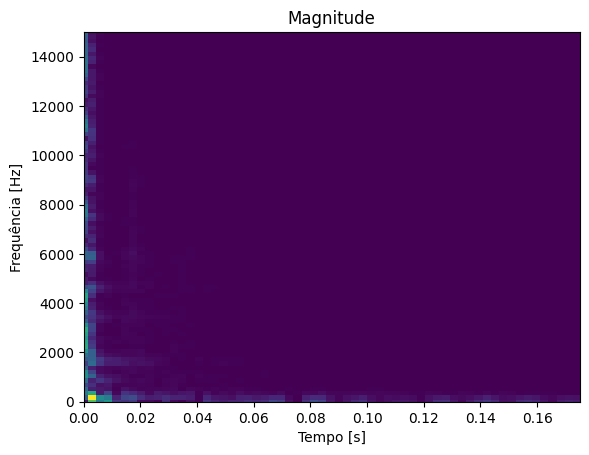

In [449]:
# agora faz-se a stft para analisar as componentes espectrais ao longo do tempo

f, t, Zxx = stft(sinal_ruido, sampling_rate)
plt.pcolormesh(t, f, np.abs(Zxx))
plt.title('Magnitude')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.xlim(0, 0.175)
plt.ylim(0, 15000)
plt.show()

Analisando o mapa de calor criado a partir da STFT é possível ver que nos primeiros segundos existe muitas componentes de frequência alta por conta do ruído branco introduzido, entretando com o decair do ruído, as componentes de frequência do sinal de áudio original (frequência mais baixas) começa a ser a única componente de frequência a ser percebida.

Note que o ponto amarelo forte no inicio do gráfico significa que a magnitude do sinal ainda é maior que a magnitude das componentes do ruído, apesar do ruído introduzir novas componentes de frequência que não existiam no sinal original.